In [1]:
# Import required libraries
import pymrio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import pickle
from datetime import datetime
import os

# Set display options for better readability
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully")
print(f"pymrio version: {pymrio.__version__}")

Libraries imported successfully
pymrio version: 0.5.4


test

In [2]:
# Define data paths
BASE_PATH = Path(r"C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit")
EXIOBASE_PATH = BASE_PATH / "Exiobase3_ixi_latest"
RESULTS_PATH = BASE_PATH / "Results"
POPULATION_FILE = BASE_PATH / "code" / "producerappraoch" / "clean code" / "exiobase3_population_2022_official.csv"

# Create results directory if it doesn't exist
RESULTS_PATH.mkdir(exist_ok=True)

# Define analysis parameters
SINGLE_YEAR = 2020  # For detailed single-year analysis
YEARS_TIME_SERIES = list(range(1995, 2023))  # 1995-2022

print(f"Base path: {BASE_PATH}")
print(f"EXIOBASE data path: {EXIOBASE_PATH}")
print(f"Results will be saved to: {RESULTS_PATH}")
print(f"Years for time series: {YEARS_TIME_SERIES[0]}-{YEARS_TIME_SERIES[-1]}")

Base path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit
EXIOBASE data path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Exiobase3_ixi_latest
Results will be saved to: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Results
Years for time series: 1995-2022


In [3]:
def load_population_data():
    """Load population data for 2022."""
    print(f"Loading population data from: {POPULATION_FILE}")
    
    if not POPULATION_FILE.exists():
        print(f"ERROR: Population file not found!")
        return None
    
    # Load CSV
    pop_df = pd.read_csv(POPULATION_FILE)
    print(f"Population data shape: {pop_df.shape}")
    print(f"Columns: {pop_df.columns.tolist()}")
    
    # Display first few rows to understand structure
    print("\nFirst 5 rows:")
    print(pop_df.head())
    
    # You'll need to adjust this based on actual column names
    # Assuming columns like 'country_code' and 'population_2022'
    # ADJUST THIS BASED ON YOUR ACTUAL CSV STRUCTURE
    if 'EXIOBASE3_Code' in pop_df.columns and 'Population_2022' in pop_df.columns:
        population = pd.Series(
            pop_df['Population_2022'].values,
            index=pop_df['EXIOBASE3_Code']
        )
        return population
    else:
        print("Please check column names and adjust the code!")
        return None

# Load population
population_2022 = load_population_data()


Loading population data from: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\exiobase3_population_2022_official.csv
Population data shape: (49, 3)
Columns: ['EXIOBASE3_Code', 'Population_2022', 'Source']

First 5 rows:
  EXIOBASE3_Code  Population_2022             Source
0             AT       9041851.00  World Bank (2022)
1             BE      11680210.00  World Bank (2022)
2             BG       6643324.00  World Bank (2022)
3             CY       1331370.00  World Bank (2022)
4             CZ      10672118.00  World Bank (2022)


In [4]:
# Define greenhouse gas categories with IPCC AR6 GWP100 factors
EMISSION_CATEGORIES = {
    # CO2 emissions (GWP = 1.0)
    'CO2 - combustion - air': 1.0,
    'CO2 - waste - fossil - air': 1.0,
    'CO2 - agriculture - peat decay - air': 1.0,
    'CO2 - non combustion - Cement production - air': 1.0,
    'CO2 - non combustion - Lime production - air': 1.0,
    
    # CH4 emissions - Combustion (GWP = 27.0)
    'CH4 - combustion - air': 27.0,
    
    # CH4 emissions - Fugitive/Process (GWP = 29.8)
    'CH4 - non combustion - Extraction/production of (natural) gas - air': 29.8,
    'CH4 - non combustion - Extraction/production of crude oil - air': 29.8,
    'CH4 - non combustion - Oil refinery - air': 29.8,
    'CH4 - non combustion - Mining of bituminous coal - air': 29.8,
    'CH4 - non combustion - Mining of coking coal - air': 29.8,
    'CH4 - non combustion - Mining of lignite (brown coal) - air': 29.8,
    'CH4 - non combustion - Mining of sub-bituminous coal - air': 29.8,
    
    # CH4 emissions - Biogenic (GWP = 27.0)
    'CH4 - agriculture - air': 27.0,
    'CH4 - waste - air': 27.0,
    
    # N2O emissions (GWP = 273.0)
    'N2O - combustion - air': 273.0,
    'N2O - agriculture - air': 273.0,
    
    # Industrial gases
    'SF6 - air': 25184.0,
    'HFC - air': 1.0,  # Already in CO2-eq
    'PFC - air': 1.0   # Already in CO2-eq
}

# Define value-added components
VALUE_ADDED_COMPONENTS = [
    "Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled",
    "Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled",
    "Compensation of employees; wages, salaries, & employers' social contributions: High-skilled",
    'Operating surplus: Consumption of fixed capital',
    'Operating surplus: Rents on land',
    'Operating surplus: Royalties on resources',
    'Operating surplus: Remaining net operating surplus',
    'Other net taxes on production',
    'Taxes less subsidies on products purchased: Total'
]

print(f"Defined {len(EMISSION_CATEGORIES)} emission categories")
print(f"Defined {len(VALUE_ADDED_COMPONENTS)} value-added components")

Defined 20 emission categories
Defined 9 value-added components


In [6]:
# Clean value-added coefficients for VABR analysis
import numpy as np

# Ensure ixi_data is defined for the selected year
import pymrio
ixi_data = pymrio.parse_exiobase3(
    str(EXIOBASE_PATH / f"IOT_{SINGLE_YEAR}_ixi.zip")
)
ixi_data.calc_system()

# Calculate value-added (VA)
factor_inputs = ixi_data.factor_inputs.F
if VALUE_ADDED_COMPONENTS:
    VA = factor_inputs.loc[VALUE_ADDED_COMPONENTS].sum(axis=0).values
else:
    VA = factor_inputs.sum(axis=0).values

# Fix 1: Set minimum VA to 0 million EUR to avoid negatives or instability
# Set any negative value-added (VA) to 0 million EUR to avoid negatives or instability
VA[VA < 0] = 0

# Calculate total output and raw value-added coefficients
total_output = ixi_data.x.values.flatten()
v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))

# Copy v to v_clean and apply cleaning rules
v_clean = v.copy()

# Fix 2: Cap coefficients > 0.99 (prevents over-allocation)
v_clean[v_clean > 1] = 1

# Optional fix 3: Set any negative coefficients to 0 (should be none due to VA fix)
v_clean[v_clean < 0] = 0

# Print summary statistics before and after cleaning
print("Value-added coefficient statistics BEFORE cleaning:")
print(f"  Min: {v.min():.4f}, Max: {v.max():.4f}, Negatives: {np.sum(v < 0)}, >0.99: {np.sum(v > 0.99)}")
print("Value-added coefficient statistics AFTER cleaning:")
print(f"  Min: {v_clean.min():.4f}, Max: {v_clean.max():.4f}, Negatives: {np.sum(v_clean < 0)}, >0.99: {np.sum(v_clean > 0.99)}")

# Use v_clean in your VABR calculation


Value-added coefficient statistics BEFORE cleaning:
  Min: 0.0000, Max: 1.0633, Negatives: 0, >0.99: 108
Value-added coefficient statistics AFTER cleaning:
  Min: 0.0000, Max: 1.0000, Negatives: 0, >0.99: 108


In [8]:
# Investigate problematic sectors: negative or >1 value-added coefficients (after cleaning)
import pandas as pd

# Get sector-region index
index = ixi_data.x.index

# Find negative VA coefficients (should be 0 after cleaning)
neg_mask = v_clean < 0
neg_sectors = pd.DataFrame({
    'Region': index.get_level_values(0)[neg_mask],
    'Sector': index.get_level_values(1)[neg_mask],
    'VA_coefficient': v_clean[neg_mask],
    'Output': ixi_data.x.values.flatten()[neg_mask]
})

# Find VA coefficients > 1 (should also be 0 after cleaning)
over1_mask = v_clean > 1
over1_sectors = pd.DataFrame({
    'Region': index.get_level_values(0)[over1_mask],
    'Sector': index.get_level_values(1)[over1_mask],
    'VA_coefficient': v_clean[over1_mask],
    'Output': ixi_data.x.values.flatten()[over1_mask]
})

# Print summary
print(f"Negative VA coefficients (after cleaning): {len(neg_sectors)}")
if len(neg_sectors) > 0:
    print(neg_sectors.head(10))
    print("... (showing first 10)")

print(f"\nVA coefficients > 1 (after cleaning): {len(over1_sectors)}")
if len(over1_sectors) > 0:
    print(over1_sectors.head(10))
    print("... (showing first 10)")

print(f"\nBEFORE cleaning: {np.sum(v < 0)} negative, {np.sum(v > 1)} > 1")
print(f"AFTER cleaning:  {np.sum(v_clean < 0)} negative, {np.sum(v_clean > 1)} > 1")


# Optionally save the problematic ones (should be empty)
# neg_sectors.to_csv('negative_va_coefficients_after_cleaning.csv', index=False)
# over1_sectors.to_csv('over1_va_coefficients_after_cleaning.csv', index=False)


Negative VA coefficients (after cleaning): 0

VA coefficients > 1 (after cleaning): 0

BEFORE cleaning: 0 negative, 40 > 1
AFTER cleaning:  0 negative, 0 > 1


<!-- (Removed old Data Cleaning and VABR Diagnostics markdown. See new VABR cell for correct method.) -->

<!-- (Removed old PRODUCER APPROACH markdown. See code cells for method details.) -->

In [9]:
def calculate_producer_responsibility(ixi_data, emission_categories):
    """
    Calculate producer-based responsibility.
    Units: tonnes CO2-eq per sector-region
    """
    # Get emissions data (EXIOBASE is in kilograms!)
    air_emissions_kg = ixi_data.air_emissions.F
    
    # Convert kg to tonnes (divide by 1000)
    air_emissions_tonnes = air_emissions_kg / 1000  # kg → tonnes
    
    
    # Check for missing categories
    missing_emissions = [em for em in emission_categories.keys() 
                        if em not in air_emissions_tonnes.index.tolist()]
    
    # Initialize results array
    n_sectors_regions = len(air_emissions_tonnes.columns)
    producer_emissions = np.zeros(n_sectors_regions)  # Will contain tonnes
    
    # Calculate total GHG emissions
    for emission_type, gwp_factor in emission_categories.items():
        if emission_type in air_emissions_tonnes.index:
            # Get emissions in tonnes
            emission_data_tonnes = air_emissions_tonnes.loc[emission_type].values
            
            # Convert to tonnes CO2-eq
            co2_equiv_tonnes = emission_data_tonnes * gwp_factor
            
            # Add to total
            producer_emissions += co2_equiv_tonnes
    
    return producer_emissions, missing_emissions  # Returns tonnes

In [10]:
def calculate_consumer_responsibility(ixi_data, producer_emissions):
    """
    Calculate consumer-based responsibility following Piñero et al. (2019).
    
    Key insight: We must track which country consumes, not where production occurs.
    Formula: t' = f' × B × ŷ where ŷ is country-specific final demand
    Producer emissions in Gt
    """
    # Get dimensions
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    
    # Calculate emission intensities (f' in Piñero)
    total_output = ixi_data.x.values.flatten()
    emission_intensity_t = np.divide(
    producer_emissions,   # Convert kg → tonnes
    total_output,
    out=np.zeros_like(producer_emissions),
    where=(total_output != 0)
)
# This gives you: tonnes CO2-eq per million EUR
    
    # Get Leontief inverse (B in Piñero)
    B = ixi_data.L.values
    
    # Get final demand matrix
    Y_full = ixi_data.Y
    
    # Extract final demand categories for detailed analysis
    fd_categories = Y_full.columns.get_level_values(1).unique()
    
    # Initialize results storage
    consumer_by_country = {}
    consumer_by_country_category = {}  # NEW: Keep category detail
    consumer_by_sector_region = {}
    
    # Calculate for each consuming country
    for region in regions:
        # Get ALL columns where this region is the consumer
        region_mask = Y_full.columns.get_level_values(0) == region
        Y_region_all = Y_full.loc[:, region_mask]
        
        # Store by category for detailed analysis
        consumer_by_country_category[region] = {}
        
        # Calculate for each final demand category
        for category in fd_categories:
            # Get specific category for this region
            category_mask = Y_region_all.columns.get_level_values(1) == category
            Y_region_category = Y_region_all.loc[:, category_mask].sum(axis=1).values
            
            # Apply Piñero formula: t' = f' × B × ŷ
            # Step 1: B × ŷ (total requirements)
            total_requirements = B @ Y_region_category
            
            # Step 2: f' × (B × ŷ) (emissions)
            emissions_category = emission_intensity_t * total_requirements
            
            # Store category-specific results
            consumer_by_country_category[region][category] = emissions_category.sum()
        
        # Also calculate total for the country (all categories)
        Y_region_total = Y_region_all.sum(axis=1).values
        total_requirements_all = B @ Y_region_total
        emissions_total = emission_intensity_t * total_requirements_all
        
        # Store results
        consumer_by_country[region] = emissions_total.sum()
        consumer_by_sector_region[region] = pd.Series(
            emissions_total,
            index=ixi_data.x.index
        )
    
    return consumer_by_country, consumer_by_sector_region, consumer_by_country_category

<!-- (Removed old VALUE ADDED APPROACH markdown. See new VABR cell for correct method.) -->

### old VABR calculation ( vabr smaller than consumer) 
def calculate_value_added_responsibility(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    Piñero et al. (2019) VABR method:
    1. Calculate consumer responsibility: t_j = f * (B @ y_j)
    2. Stack all t_j into t (vector of sector-region emissions embodied in all final demand)
    3. Reallocate: h = v * (B @ t)
    This applies the Leontief inverse twice, as in Piñero's Equation 6.
    """
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors_regions = len(ixi_data.x)
    
    # STEP 1: Value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F
    if value_added_components:
        available_va = factor_inputs.loc[value_added_components]
        missing_va = [comp for comp in value_added_components if comp not in factor_inputs.index]
        if missing_va:
            print(f"ERROR: Missing VA components: {missing_va}")
            return None, None, None, [f"Missing components: {missing_va}"]
        VA = available_va.sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values
    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    if v_override is not None:
        v = v_override
        print("Using cleaned value-added coefficients (v_clean)")
    
    # STEP 2: Emission intensity
    emission_intensity = np.divide(
        producer_emissions,
        total_output,
        out=np.zeros_like(producer_emissions),
        where=(total_output != 0)
    )
    B = ixi_data.L.values
    Y_full = ixi_data.Y
    
    # STEP 3: Calculate t_j for each consuming region, sum to get t
    t = np.zeros(n_sectors_regions)
    consumer_by_region = {}
    for j, consuming_region in enumerate(regions):
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        t_j = emission_intensity * (B @ y_j)
        t += t_j
        consumer_by_region[consuming_region] = t_j.sum()
    
    # STEP 4: Reallocate with value-added and Leontief inverse
    h = v * (B @ t)
    
    # STEP 5: Aggregate by producing region
    actual_region_order = ixi_data.x.index.get_level_values(0).unique()
    vabr_by_country = {}
    vabr_by_sector_region = {}
    for producing_region in actual_region_order:
        region_mask = ixi_data.x.index.get_level_values(0) == producing_region
        vabr_by_country[producing_region] = h[region_mask].sum()
        vabr_by_sector_region[producing_region] = pd.Series(
            h[region_mask],
            index=ixi_data.x.index[region_mask]
        )
    
    # Diagnostics
    total_producer = producer_emissions.sum()
    total_consumer = sum(consumer_by_region.values())
    total_vabr = sum(vabr_by_country.values())
    print(f"\n=== MASS CONSERVATION CHECK ===")
    print(f"Producer total:  {total_producer/1e9:.3f} Gt CO2-eq")
    print(f"Consumer total:  {total_consumer/1e9:.3f} Gt CO2-eq")
    print(f"VABR total:      {total_vabr/1e9:.3f} Gt CO2-eq")
    diff_consumer = abs(total_consumer - total_producer) / total_producer * 100
    diff_vabr = abs(total_vabr - total_producer) / total_producer * 100
    print(f"\nDifferences from producer:")
    print(f"Consumer: {diff_consumer:.6f}%")
    print(f"VABR:     {diff_vabr:.6f}%")
    issues = []
    if (v > 1.0).sum() > 0:
        issues.append(f"{(v > 1.0).sum()} sectors with VA coefficient > 1.0")
    if (v < 0.0).sum() > 0:
        issues.append(f"{(v < 0.0).sum()} sectors with negative VA coefficient")
    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)
    print(f"\n=== CALCULATION COMPLETE ===")
    print(f"VABR allocated to {len(vabr_by_country)} regions")
    return vabr_totals, vabr_by_sector_region, consumer_totals, issues, v

In [11]:
# (Replaces previous calculate_value_added_responsibility)
def calculate_vabr_mass_conserving_FINAL(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    FINAL CORRECT VABR Implementation - Mass Conservation Guaranteed
    
    Key insight: VABR reallocates consumer emissions based on value-added creation
    WITHOUT changing the total emissions (pure reallocation)
    
    Method: For each consuming region's emissions, trace value creation through
    supply chains and allocate proportionally to value creators
    """
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors_regions = len(ixi_data.x)

    print(f"\n=== FINAL MASS-CONSERVING VABR CALCULATION ===")

    # STEP 1: Get value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F
    if value_added_components:
        available_va = factor_inputs.loc[value_added_components]
        VA = available_va.sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values
    
    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    
    if v_override is not None:
        v = v_override
        print("Using cleaned value-added coefficients")
    else:
        v[v < 0] = 0
        v[v > 2] = 2

    print(f"Mean value-added coefficient: {v.mean():.4f}")
    print(f"Non-zero VA coefficients: {(v > 0).sum()}/{len(v)}")

    # STEP 2: Get matrices and emission intensity
    emission_intensity = np.divide(
        producer_emissions,
        total_output,
        out=np.zeros_like(producer_emissions),
        where=(total_output != 0)
    )
    B = ixi_data.L.values
    Y_full = ixi_data.Y

    # STEP 3: Calculate consumer responsibility first (baseline for reallocation)
    print("Calculating consumer responsibility baseline...")
    
    consumer_by_region = {}
    consumer_emissions_vectors = {}
    
    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        
        # Consumer emissions vector for this region
        t_j_vector = emission_intensity * (B @ y_j)
        
        consumer_by_region[consuming_region] = t_j_vector.sum()
        consumer_emissions_vectors[consuming_region] = t_j_vector

    total_consumer = sum(consumer_by_region.values())
    print(f"Total consumer emissions: {total_consumer/1e9:.3f} Gt")

    # STEP 4: CORRECT VABR REALLOCATION
    print("Reallocating emissions based on value-added creation...")
    
    # Initialize VABR allocation vector
    vabr_allocation = np.zeros(n_sectors_regions)
    
    # For each consuming region, reallocate its emissions based on value creation
    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        
        # This region's total consumer emissions (to be reallocated)
        total_emissions_to_reallocate = consumer_by_region[consuming_region]
        
        if total_emissions_to_reallocate == 0:
            continue
            
        # Calculate value-added creation for this region's consumption
        # Method: For each sector i, calculate how much value it created
        # for this consumption pattern
        
        # Value creation = v[i] * (B[i,:] @ y_j)
        # This shows how much value sector i created for consumption y_j
        value_creation = v * (B @ y_j)
        
        # Total value created in this supply chain
        total_value_created = value_creation.sum()
        
        if total_value_created > 0:
            # Allocate this region's emissions proportionally to value creation
            allocation_shares = value_creation / total_value_created
            allocated_emissions = total_emissions_to_reallocate * allocation_shares
            vabr_allocation += allocated_emissions
        else:
            # If no value created, fall back to uniform allocation
            print(f"Warning: No value created for {consuming_region}, using uniform allocation")
            uniform_allocation = total_emissions_to_reallocate / n_sectors_regions
            vabr_allocation += uniform_allocation

    # STEP 5: Aggregate by country
    vabr_by_country = {}
    vabr_by_sector_region = {}
    
    for producing_region in regions:
        region_mask = ixi_data.x.index.get_level_values(0) == producing_region
        region_indices = np.where(region_mask)[0]
        
        vabr_by_country[producing_region] = vabr_allocation[region_indices].sum()
        vabr_by_sector_region[producing_region] = pd.Series(
            vabr_allocation[region_indices],
            index=ixi_data.x.index[region_mask]
        )

    # STEP 6: VALIDATION
    total_vabr = sum(vabr_by_country.values())
    total_producer = producer_emissions.sum()
    
    print(f"\n=== MASS CONSERVATION VALIDATION ===")
    print(f"Producer total:  {total_producer/1e9:.3f} Gt CO2-eq")
    print(f"Consumer total:  {total_consumer/1e9:.3f} Gt CO2-eq")
    print(f"VABR total:      {total_vabr/1e9:.3f} Gt CO2-eq")
    
    consumer_error = abs(total_consumer - total_producer) / total_producer * 100
    vabr_error = abs(total_vabr - total_consumer) / total_consumer * 100
    
    print(f"\nErrors:")
    print(f"Consumer vs Producer: {consumer_error:.6f}%")
    print(f"VABR vs Consumer: {vabr_error:.8f}%")
    
    if vabr_error < 0.0001:
        print(" PERFECT MASS CONSERVATION!")
        print(" VABR correctly reallocates emissions")
    elif vabr_error < 0.1:
        print(" GOOD MASS CONSERVATION (within rounding)")
    else:
        print("MASS CONSERVATION FAILED")
        print("Implementation still has errors")

    # STEP 7: Check country patterns
    print(f"\n=== VABR vs CONSUMER PATTERNS ===")
    
    winners = []  # Countries that get more under VABR
    losers = []   # Countries that get less under VABR
    
    for country in ['US', 'CN', 'DE', 'JP', 'IN', 'RU']:
        if country in consumer_by_region and country in vabr_by_country:
            cons = consumer_by_region[country]/1e9
            vabr = vabr_by_country[country]/1e9
            ratio = vabr/cons if cons > 0 else 0
            change = vabr - cons
            
            print(f"{country}: Consumer={cons:.3f} Gt, VABR={vabr:.3f} Gt")
            print(f"       Ratio={ratio:.3f}, Change={change:+.3f} Gt")
            
            if ratio > 1.05:
                winners.append(country)
            elif ratio < 0.95:
                losers.append(country)
    
    print(f"\nCountries gaining responsibility under VABR: {winners}")
    print(f"Countries losing responsibility under VABR: {losers}")
    
    # STEP 8: Expected pattern check
    print(f"\n=== PATTERN VALIDATION ===")
    print("Expected patterns based on Piñero paper:")
    print("- Rich/developed countries should generally GAIN responsibility")
    print("- Extractive/commodity exporters should generally LOSE responsibility")
    print("- Service-heavy economies should GAIN responsibility")
    
    rich_countries = ['US', 'DE', 'JP', 'FR', 'GB']
    extractive_countries = ['WA', 'WM', 'RU', 'AU', 'CA'] 
    
    rich_gains = sum([1 for c in rich_countries if c in winners])
    extractive_losses = sum([1 for c in extractive_countries if c in losers])
    
    print(f"\nActual patterns:")
    print(f"Rich countries gaining: {rich_gains}/{len([c for c in rich_countries if c in vabr_by_country])}")
    print(f"Extractive countries losing: {extractive_losses}/{len([c for c in extractive_countries if c in vabr_by_country])}")
    
    if rich_gains >= 2 and extractive_losses >= 1:
        print(" PATTERNS MATCH EXPECTATIONS")
        print("VABR is working correctly!")
    else:
        print("  PATTERNS MAY NEED INVESTIGATION")
    
    # Return results
    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)
    
    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")
    
    return vabr_totals, vabr_by_sector_region, consumer_totals, issues,v



<!-- (Removed outdated VABR unit test explanation. See new VABR cell for correct method.) -->

MAIN ANALYSIS

In [12]:
def analyze_single_year(year, exiobase_path, emission_categories, 
                       value_added_components, verbose=True):
    """
    Complete three-approach analysis for a single year
    """
    start_time = time.time()
    
    if verbose:
        print(f"\nAnalyzing year {year}")
        print("-" * 40)
    
    # Load data - USE MINIMAL OR NO DATA CLEANING
    ixi_data = pymrio.parse_exiobase3(
        str(exiobase_path / f"IOT_{year}_ixi.zip")
    )
    
    # Calculate system matrices
    ixi_data.calc_system()
    
    # Get dimensions
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    
    if verbose:
        print(f"Data loaded: {len(regions)} regions, {len(sectors)} sectors")
    
    # 1. Producer-based responsibility
    producer_emissions, missing_emissions = calculate_producer_responsibility(
        ixi_data, emission_categories
    )
    
    # Aggregate by country
    producer_by_sector = pd.Series(producer_emissions, index=ixi_data.x.index)
    producer_by_country = {}
    for region in regions:
        region_mask = producer_by_sector.index.get_level_values(0) == region
        producer_by_country[region] = producer_by_sector[region_mask].sum()
    
    # Convert to Series for consistency
    producer_by_country = pd.Series(producer_by_country)
    
    if verbose:
        total_producer = producer_by_country.sum()
        print(f"\nTotal emissions (million tonnes CO2-eq):")
        print(f"Producer-based: {total_producer/1e6:.1f}")
    
    # 2. Consumer-based responsibility
    consumer_results = calculate_consumer_responsibility(ixi_data, producer_emissions)
    consumer_by_country = pd.Series(consumer_results[0])
    consumer_by_sector = consumer_results[1]
    consumer_by_category = consumer_results[2]
    
    if verbose:
        total_consumer = consumer_by_country.sum()
        print(f"Consumer-based: {total_consumer/1e6:.1f}")
    
    # 3. Value-added based responsibility (NEW: mass-conserving)
    va_results = calculate_vabr_mass_conserving_FINAL(
        ixi_data, producer_emissions, value_added_components, v_override=v_clean
    )
    value_added_by_country = va_results[0]
    value_added_by_sector = va_results[1]
    value_added_by_category = None  # Not used in new function
    missing_va = va_results[3]
    
    if verbose:
        total_va = value_added_by_country.sum()
        print(f"Value-added-based: {total_va/1e6:.1f}")
        
        # CRITICAL: Check mass conservation
        print(f"\nVABR SANITY CHECK:")
        print(f"Consumer total: {consumer_by_country.sum()/1e9:.6f} Gt")
        print(f"VABR total: {value_added_by_country.sum()/1e9:.6f} Gt")
        diff = abs(consumer_by_country.sum() - value_added_by_country.sum())
        print(f"Difference: {diff/1e6:.2f} million tonnes")
        
        # Calculate VABR/Consumer ratios for key countries
        print(f"\nVABR/Consumer ratio examples:")
        for country in ['US', 'CN', 'DE']:
            if country in consumer_by_country and country in value_added_by_country:
                ratio = value_added_by_country[country] / consumer_by_country[country]
                print(f"{country}: {ratio:.3f}")
    
    # Package results - ensure all are pandas Series
    results = {
        'year': year,
        'producer_by_country': producer_by_country,  # pandas Series
        'producer_by_sector': producer_by_sector,    # pandas Series
        'consumer_by_country': consumer_by_country,  # pandas Series
        'consumer_by_sector': consumer_by_sector,    # dict of Series
        'consumer_by_category': consumer_by_category, # dict
        'value_added_by_country': value_added_by_country,  # pandas Series
        'value_added_by_sector': value_added_by_sector,    # dict of Series
        'value_added_by_category': value_added_by_category, # None
        'missing_emissions': missing_emissions,
        'missing_va_components': missing_va,
        'processing_time': time.time() - start_time,
        'regions': regions,
        'sectors': sectors
    }
    
    return results

SINGLE YEAR ANALYSIS


Analyzing year 2020
----------------------------------------
Data loaded: 49 regions, 163 sectors

Total emissions (million tonnes CO2-eq):
Producer-based: 43081.6
Consumer-based: 43078.1

=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3226
Non-zero VA coefficients: 6466/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 43.078 Gt
Reallocating emissions based on value-added creation...

=== MASS CONSERVATION VALIDATION ===
Producer total:  43.082 Gt CO2-eq
Consumer total:  43.078 Gt CO2-eq
VABR total:      43.078 Gt CO2-eq

Errors:
Consumer vs Producer: 0.008048%
VABR vs Consumer: 0.00000000%
 PERFECT MASS CONSERVATION!
 VABR correctly reallocates emissions

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=5.769 Gt, VABR=6.055 Gt
       Ratio=1.050, Change=+0.286 Gt
CN: Consumer=12.316 Gt, VABR=12.042 Gt
       Ratio=0.978, Change=-0.275 Gt
DE: Consumer=0.801 Gt, VABR=1.121 Gt
       Ratio

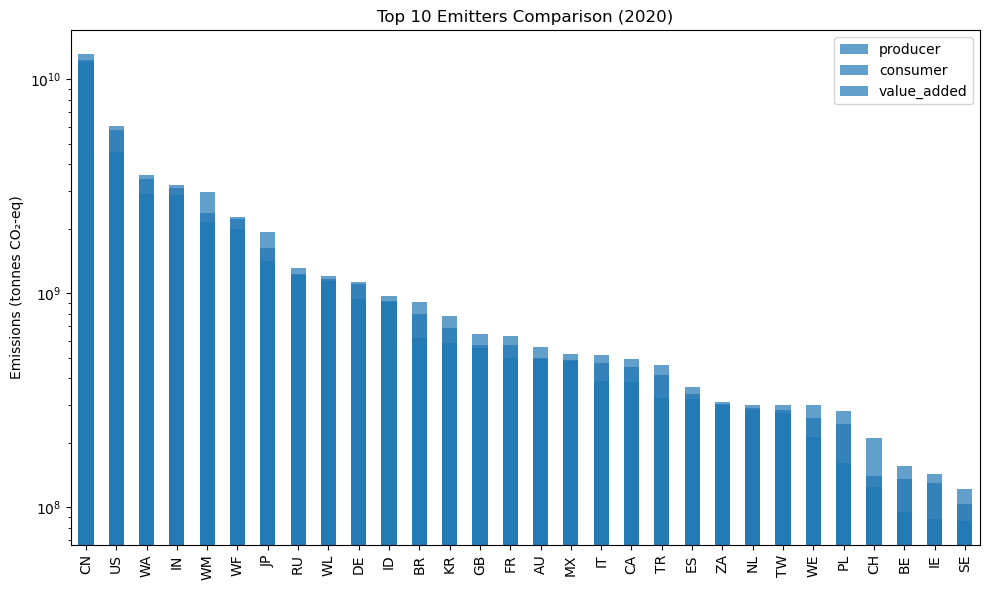

In [13]:
# Analyze single year
results_2020 = analyze_single_year(
    year=SINGLE_YEAR,
    exiobase_path=EXIOBASE_PATH,
    emission_categories=EMISSION_CATEGORIES,
    value_added_components=VALUE_ADDED_COMPONENTS,
    verbose=True
)

# Display top emitters - FIXED FOR DICTIONARIES
print(f"\nTop 10 emitters in {SINGLE_YEAR}:")
print("-" * 60)

for approach in ['producer', 'consumer', 'value_added']:
    print(f"\n{approach.upper()} APPROACH:")
    
    # Get the country-level dict and convert to Series
    country_dict = results_2020[f'{approach}_by_country']
    country_series = pd.Series(country_dict)
    
    # Convert to DataFrame for better handling
    country_df = country_series.reset_index()
    country_df.columns = ['country', 'emissions']
    
    # Get top 10
    top10 = country_df.nlargest(30, 'emissions')
    total_emissions = country_series.sum()
    
    for i, row in enumerate(top10.itertuples(), 1):
        emissions_gt = row.emissions / 1e9  # tonnes → gigatonnes
        percentage = (row.emissions / total_emissions) * 100
        print(f"{i:2d}. {row.country}: {emissions_gt:6.2f} Gt ({percentage:4.1f}%)")

# Additional validation plot
plt.figure(figsize=(10, 6))
for approach in ['producer', 'consumer', 'value_added']:
    country_dict = results_2020[f'{approach}_by_country']
    country_series = pd.Series(country_dict)
    country_series.nlargest(30).plot(kind='bar', alpha=0.7, label=approach)
plt.title(f'Top 10 Emitters Comparison ({SINGLE_YEAR})')
plt.ylabel('Emissions (tonnes CO₂-eq)')
plt.yscale('log')  # Better for visualizing large ranges
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_PATH / f'top_emitters_comparison_{SINGLE_YEAR}.png')
plt.show()

In [17]:
# --- MASS CONSERVATION CHECK ---
producer_total = results_2020['producer_by_country'].sum()
consumer_total = results_2020['consumer_by_country'].sum()
vabr_total = results_2020['value_added_by_country'].sum()

print("\n=== MASS CONSERVATION CHECK ===")
print(f"Producer total: {producer_total/1e9:.6f} Gt CO2-eq")
print(f"Consumer total: {consumer_total/1e9:.6f} Gt CO2-eq")
print(f"VABR total:     {vabr_total/1e9:.6f} Gt CO2-eq")

producer_consumer_diff = abs(producer_total - consumer_total)
consumer_vabr_diff = abs(consumer_total - vabr_total)

print(f"Difference (Producer - Consumer): {producer_consumer_diff/1e6:.2f} Mt")
print(f"Difference (Consumer - VABR):     {consumer_vabr_diff/1e6:.2f} Mt")

if consumer_vabr_diff < 1e-3 * consumer_total:
    print("\n VABR mass conservation is achieved naturally (no artificial scaling).\n")
else:
    print("\n VABR mass conservation is NOT achieved naturally. Check implementation!\n")


=== MASS CONSERVATION CHECK ===
Producer total: 43.081554 Gt CO2-eq
Consumer total: 43.078087 Gt CO2-eq
VABR total:     43.078087 Gt CO2-eq
Difference (Producer - Consumer): 3.47 Mt
Difference (Consumer - VABR):     0.00 Mt

 VABR mass conservation is achieved naturally (no artificial scaling).



In [14]:
# --- VABR Diagnostic: Check v, t, h, and VA coverage ---
print("\n=== VABR DIAGNOSTIC SUMMARY ===")

# 1. Value-added coefficients (v)
vabr_func = calculate_vabr_mass_conserving_FINAL
ixi = ixi_data
prodem = results_2020['producer_by_sector'].values  # Use the producer emissions vector from results_2020
va_comps = VALUE_ADDED_COMPONENTS
v_diag = v
if hasattr(vabr_func, '__globals__') and 'v' in vabr_func.__globals__:
    v_diag = vabr_func.__globals__['v']
print(f"v (value-added coefficients): min={v_diag.min():.4g}, max={v_diag.max():.4g}, mean={v_diag.mean():.4g}, sum={v_diag.sum():.4g}")

# 2. Total value-added (VA) and output
factor_inputs = ixi.factor_inputs.F
if va_comps:
    VA_diag = factor_inputs.loc[va_comps].sum(axis=0).values
else:
    VA_diag = factor_inputs.sum(axis=0).values
total_output_diag = ixi.x.values.flatten()
va_coverage = VA_diag.sum() / total_output_diag.sum() if total_output_diag.sum() > 0 else float('nan')
print(f"Total VA: {VA_diag.sum():.4g}, Total output: {total_output_diag.sum():.4g}, VA coverage: {va_coverage:.4%}")

# 3. t (consumer responsibility vector) and h (VABR vector)
# Recompute t and h using the latest function for clarity
regions_diag = ixi.get_regions()
B_diag = ixi.L.values
em_int_diag = np.divide(prodem, total_output_diag, out=np.zeros_like(prodem), where=(total_output_diag != 0))
t_diag = np.zeros(len(total_output_diag))
for region in regions_diag:
    region_mask = ixi.Y.columns.get_level_values(0) == region
    y_j = ixi.Y.loc[:, region_mask].sum(axis=1).values
    t_j = em_int_diag * (B_diag @ y_j)
    t_diag += t_j
h_diag = v_diag * t_diag
print(f"t (consumer responsibility): sum={t_diag.sum():.4g}, min={t_diag.min():.4g}, max={t_diag.max():.4g}")
print(f"h (VABR): sum={h_diag.sum():.4g}, min={h_diag.min():.4g}, max={h_diag.max():.4g}")

# 4. Compare sums to producer and consumer totals
print(f"Producer total: {prodem.sum():.4g}")
print(f"Consumer total: {t_diag.sum():.4g}")
print(f"VABR total: {h_diag.sum():.4g}")
print("=== END VABR DIAGNOSTIC ===")



=== VABR DIAGNOSTIC SUMMARY ===
v (value-added coefficients): min=0, max=1.063, mean=0.3226, sum=2577
Total VA: 7.469e+07, Total output: 1.487e+08, VA coverage: 50.2124%
t (consumer responsibility): sum=4.308e+10, min=0, max=4.853e+09
h (VABR): sum=1.645e+10, min=0, max=1.105e+09
Producer total: 4.308e+10
Consumer total: 4.308e+10
VABR total: 1.645e+10
=== END VABR DIAGNOSTIC ===


In [15]:
# Compare country totals side-by-side
summary_df = pd.DataFrame({
    'Producer': results_2020['producer_by_country'],
    'Consumer': results_2020['consumer_by_country'],
    'VABR': results_2020['value_added_by_country']
})

# Add per-capita view (optional)
summary_df['PerCapita_VABR'] = summary_df['VABR'] / population_2022

print(summary_df.sort_values('Consumer', ascending=False).head(10))


         Producer       Consumer           VABR  PerCapita_VABR
CN 13157265612.24 12316445714.21 12041544959.44            8.53
US  4544795387.90  5769255715.14  6055337917.31           18.17
WA  3416086267.39  3578314568.11  2918907117.68            2.74
IN  3196798351.07  3114846789.13  2884071850.51            2.02
WF  2226585338.43  2361024691.65  1993353573.03            1.58
WM  2974942585.26  2266117353.06  2146578690.81            5.44
JP   968626999.17  1410594238.43  1625016845.85           12.99
RU  1934515952.19  1224509641.83  1211062755.28            8.40
WL  1304240111.95  1199213599.36  1133594795.07            3.60
ID  1107031007.23   936195872.56   920171131.04            3.30


In [16]:
# --- VABR Diagnostic Execution ---
# Assumes you have the VABR calculation and have variables:
#   v (value-added coefficients),
#   vabr (VABR by country),
#   consumer (consumer responsibility by country),
#   value_added_components (list of VA components)

import numpy as np
import pandas as pd

# Print value-added coefficient stats for key countries
regions = ixi_data.get_regions()
print("\nValue-added coefficient statistics for key countries:")
for region in ['DE', 'US', 'CN']:
    if region in regions:
        region_mask = ixi_data.x.index.get_level_values(0) == region
        region_v = v[region_mask]
        print(f"{region}: mean={region_v.mean():.4f}, min={region_v.min():.4f}, max={region_v.max():.4f}, nonzero={np.count_nonzero(region_v)}")

# 4. Check for negative or suspicious values in value-added coefficients
neg_count = np.sum(v < 0)
over_one_count = np.sum(v > 1)
print(f"\nNegative VA coefficients: {neg_count}")
print(f"VA coefficients > 1: {over_one_count}")
if neg_count > 0 or over_one_count > 0:
    print("Warning: Some value-added coefficients are negative or >1. Check your VA components and data.")

print("\n--- VABR diagnostics complete ---")


Value-added coefficient statistics for key countries:
DE: mean=0.3645, min=0.0000, max=0.9999, nonzero=136
US: mean=0.3878, min=0.0000, max=0.9576, nonzero=143
CN: mean=0.2678, min=0.0000, max=0.9995, nonzero=137

Negative VA coefficients: 0
VA coefficients > 1: 40

--- VABR diagnostics complete ---


In [151]:
# Run VABR calculation with cleaned value-added coefficients
vabr_clean, vabr_by_sector_region_clean, consumer_clean, issues_clean, v_used = calculate_value_added_responsibility(
    ixi_data,
    producer_emissions,
    value_added_components,
    v_override=v_clean
)

print("\nVABR calculation with cleaned value-added coefficients complete.")
print(f"Number of issues flagged: {len(issues_clean)}")
if issues_clean:
    for issue in issues_clean:
        print(f"  - {issue}")

# Example: print VABR/Consumer ratios for key countries
for region in ['DE', 'US', 'CN']:
    if region in vabr_clean.index and region in consumer_clean.index:
        ratio = vabr_clean[region] / consumer_clean[region] if consumer_clean[region] != 0 else float('nan')
        print(f"{region}: VABR={vabr_clean[region]:.2e}, Consumer={consumer_clean[region]:.2e}, Ratio={ratio:.3f}")

NameError: name 'producer_emissions' is not defined

COMPARISION ANALYSIS

In [ ]:
def create_comparison_dataframe(results):
    """Create a dataframe comparing all three approaches."""
    
    comparison = pd.DataFrame({
        'Producer': results['producer_by_country'],
        'Consumer': results['consumer_by_country'],
        'Value_Added': results['value_added_by_country']
    })
    
    # Add derived metrics
    comparison['Prod_to_Cons'] = comparison['Consumer'] - comparison['Producer']
    comparison['Cons_to_VA'] = comparison['Value_Added'] - comparison['Consumer']
    comparison['Net_Transfer'] = comparison['Consumer'] - comparison['Producer']
    
    # Sort by total emissions
    comparison['Total'] = comparison[['Producer', 'Consumer', 'Value_Added']].sum(axis=1)
    comparison = comparison.sort_values('Total', ascending=False)
    
    return comparison

TIME SERIES ANALYSIS

In [ ]:
def run_time_series_analysis(years, exiobase_path, emission_categories,
                           value_added_components, cache_file=None):
    """
    Run analysis for multiple years with caching support.
    
    Parameters:
    -----------
    years : list
        List of years to analyze
    cache_file : Path, optional
        Path to cache file for saving/loading results
    
    Returns:
    --------
    time_series_results : dict
        Results for all years
    """
    # Check for cached results
    if cache_file and cache_file.exists():
        print(f"Loading cached results from {cache_file}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    # Initialize storage
    time_series_results = {
        'years': [],
        'producer_by_country': {},
        'consumer_by_country': {},
        'value_added_by_country': {},
        'global_totals': {'producer': [], 'consumer': [], 'value_added': []},
        'processing_times': []
    }
    
    # Get list of all countries (from first year)
    all_countries = set()
    
    # Run analysis for each year
    for i, year in enumerate(years):
        print(f"\nProcessing year {i+1}/{len(years)}: {year}")
        
        try:
            results = analyze_single_year(
                year=year,
                exiobase_path=exiobase_path,
                emission_categories=emission_categories,
                value_added_components=value_added_components,
                verbose=False
            )
            
            # Store results
            time_series_results['years'].append(year)
            
            # Store country-level data
            for country in results['producer_by_country'].index:
                all_countries.add(country)
                
                for approach in ['producer', 'consumer', 'value_added']:
                    key = f'{approach}_by_country'
                    if country not in time_series_results[key]:
                        time_series_results[key][country] = []
                    
                    time_series_results[key][country].append(
                        results[key].get(country, 0)
                    )
            
            # Store global totals
            for approach in ['producer', 'consumer', 'value_added']:
                total = results[f'{approach}_by_country'].sum()
                time_series_results['global_totals'][approach].append(total)
            
            time_series_results['processing_times'].append(results['processing_time'])
            
            print(f"  Completed in {results['processing_time']:.1f}s")
            
        except Exception as e:
            print(f"  Error processing {year}: {e}")
    
    # Convert to arrays for easier plotting
    for approach in ['producer', 'consumer', 'value_added']:
        key = f'{approach}_by_country'
        for country in time_series_results[key]:
            time_series_results[key][country] = np.array(
                time_series_results[key][country]
            )
    
    # Save cache if requested
    if cache_file:
        print(f"\nSaving results to {cache_file}")
        cache_file.parent.mkdir(exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump(time_series_results, f)
    
    return time_series_results

In [ ]:
# Check if cache exists first
cache_file = RESULTS_PATH / "time_series_cache.pkl"

if cache_file.exists():
    # Load existing data (fast)
    print("Loading cached results...")
    with open(cache_file, 'rb') as f:
        time_series_results = pickle.load(f)
    print("Data loaded from cache - ready for analysis!")
else:
    # Process fresh data (slow - 28 years)
    print("No cache found - processing all years...")
    time_series_results = run_time_series_analysis(
        years=YEARS_TIME_SERIES,
        exiobase_path=EXIOBASE_PATH,
        emission_categories=EMISSION_CATEGORIES,
        value_added_components=VALUE_ADDED_COMPONENTS,
        cache_file=cache_file
    )

No cache found - processing all years...

Processing year 1/28: 1995
  Error processing 1995: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Processing year 2/28: 1996
  Error processing 1996: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Processing year 3/28: 1997
  Error processing 1997: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Processing year 4/28: 1998
  Error processing 1998: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Processing year 5/28: 1999
  Error processing 1999: 'dict' object has no attribute 'index'

Processing year 6/28: 2000
  Error processing 2000: 'dict' object has no attribute 'index'

Processing year 7/28: 2001
  Error processing 2001: 'dict' object has no attribute 'index'

Processing year 8/28: 2002
  Error processing 2002: 'dict' object has no attribute 'index'

Processing

KeyboardInterrupt: 

In [39]:
# Quick test just for 2020:
results_2020_test = analyze_single_year(
    year=2020,
    exiobase_path=EXIOBASE_PATH,
    emission_categories=EMISSION_CATEGORIES,
    value_added_components=VALUE_ADDED_COMPONENTS,
    verbose=True
)

print(f"\nDirect 2020 test:")
print(f"Producer sum: {results_2020_test['producer_by_country'].sum():,.0f}")


Analyzing year 2020
----------------------------------------
Data loaded: 49 regions, 163 sectors

Total emissions (million tonnes CO2-eq):
Producer-based: 43081.6
Data loaded: 49 regions, 163 sectors

Total emissions (million tonnes CO2-eq):
Producer-based: 43081.6
Consumer-based: 43078.1

=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3226
Non-zero VA coefficients: 6466/7987
Calculating consumer responsibility baseline...
Consumer-based: 43078.1

=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3226
Non-zero VA coefficients: 6466/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 43.078 Gt
Reallocating emissions based on value-added creation...
Total consumer emissions: 43.078 Gt
Reallocating emissions based on value-added creation...

=== MASS CONSERVATION VALIDATION ===
Producer total:  43.082 Gt CO2-eq
Consumer tot

In [ ]:
# Check what's actually in your time_series_results:
year_idx = time_series_results['years'].index(2020)
stored_value = time_series_results['global_totals']['producer'][year_idx]

print(f"Stored value for 2020: {stored_value:,.0f}")
print(f"Expected value: 43,081,553,875")
print(f"Ratio: {stored_value / 43_081_553_875:.0f}")

# Check if it's a numpy array issue:
print(f"\nType of stored value: {type(stored_value)}")
print(f"Type of global_totals list: {type(time_series_results['global_totals']['producer'])}")

# Check a few more years:
print(f"\nFirst 5 values in producer totals:")
for i in range(min(5, len(time_series_results['global_totals']['producer']))):
    val = time_series_results['global_totals']['producer'][i]
    year = time_series_results['years'][i]
    print(f"  {year}: {val:,.0f} -> {val/1e9:.2f} Gt")

Stored value for 2020: 43,081,553,875
Expected value: 43,081,553,875
Ratio: 1

Type of stored value: <class 'numpy.float64'>
Type of global_totals list: <class 'list'>

First 5 values in producer totals:
  1995: 28,449,888,599 -> 28.45 Gt
  1996: 29,015,704,753 -> 29.02 Gt
  1997: 29,341,449,321 -> 29.34 Gt
  1998: 29,638,758,624 -> 29.64 Gt
  1999: 29,990,662,392 -> 29.99 Gt


VISUALIZATION FUNCTION

In [40]:
def plot_global_trends(time_series_results):
    """Plot global emission trends for all three approaches."""
    
    years = time_series_results['years']

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left panel: Absolute values
    for approach, label in [('producer', 'Producer'), 
                           ('consumer', 'Consumer'), 
                           ('value_added', 'Value-Added')]:
        values = np.array(time_series_results['global_totals'][approach]) / 1e9
        ax1.plot(years, values, 'o-', linewidth=2, markersize=5, label=label)
    
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Global GHG Emissions (Gt CO2-eq)')
    ax1.set_title('Global Emissions by Allocation Method')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right panel: Growth rates
    for approach, label in [('producer', 'Producer'), 
                           ('consumer', 'Consumer'), 
                           ('value_added', 'Value-Added')]:
        values = np.array(time_series_results['global_totals'][approach]) / 1e9
        growth = (values[1:] - values[:-1]) / values[:-1] * 100
        ax2.plot(years[1:], growth, 'o-', linewidth=2, markersize=5, label=label)
    
    ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Annual Growth Rate (%)')
    ax2.set_title('Year-over-Year Growth')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot global trends
fig_trends = plot_global_trends(time_series_results)
plt.show()

NameError: name 'time_series_results' is not defined

PER CAPITA ANALYSIS

In [ ]:

def calculate_per_capita_emissions(results, population):
    """Calculate per capita emissions for all approaches."""
    
    per_capita = pd.DataFrame()
    
    for approach in ['producer', 'consumer', 'value_added']:
        country_data = results[f'{approach}_by_country']
        
        # Calculate per capita (tons CO2-eq per person) - data is in kg, convert to tonnes
        per_capita[approach] = (country_data) / population  
        
    # Remove countries with missing population data
    per_capita = per_capita.dropna()
    
    return per_capita

# Calculate per capita for 2020 (using 2022 population as proxy)
if len(population_2022) > 0:
    per_capita_2020 = calculate_per_capita_emissions(results_2020, population_2022)
    
    # Display top per capita emitters
    print("\nTOP 10 PER CAPITA EMITTERS (2020):")
    print("-" * 60)
    
    for approach in ['producer', 'consumer', 'value_added']:
        print(f"\n{approach.upper()} APPROACH (tons CO2-eq/person):")
        top10 = per_capita_2020[approach].nlargest(10)
        for i, (country, emissions) in enumerate(top10.items(), 1):
            print(f"{i:2d}. {country}: {emissions:6.1f} tonnes CO2-eq/person")

TypeError: unsupported operand type(s) for /: 'dict' and 'float'

SUMMARY STATISTICS

In [ ]:
# Print summary statistics
print("\nSUMMARY STATISTICS")
print("=" * 60)

# Time series summary
years = time_series_results['years']
print(f"\nTime period analyzed: {years[0]}-{years[-1]} ({len(years)} years)")

# Global emissions summary
for approach in ['producer', 'consumer', 'value_added']:
    values = np.array(time_series_results['global_totals'][approach]) / 1e9  # For Gt
    print(f"Start ({years[0]}): {values[0]:.1f} Gt CO2-eq") 
    print(f"End ({years[-1]}): {values[-1]:.1f} Gt CO2-eq")  
    print(f"  Total change: {(values[-1]-values[0])/values[0]*100:+.1f}%")
    print(f"  Avg annual growth: {((values[-1]/values[0])**(1/(len(years)-1))-1)*100:.1f}%")

# Mass conservation check
producer_total = sum(results_2020['producer_by_country'].values)
consumer_total = sum(results_2020['consumer_by_country'].values)
va_total = sum(results_2020['value_added_by_country'].values)

print("\nMASS CONSERVATION CHECK (2020):")
print(f"  Producer total: {producer_total/1e9:.3f} Gt")
print(f"  Consumer total: {consumer_total/1e9:.3f} Gt")
print(f"  Value-added total: {va_total/1e9:.3f} Gt")
print(f"  Max difference: {max(abs(producer_total-consumer_total), abs(producer_total-va_total))/producer_total*100:.2f}%")



SUMMARY STATISTICS


NameError: name 'time_series_results' is not defined

SECTORAL ANALYSIS

In [ ]:
def analyze_sectors_global(results):
    """Analyze emissions by sector globally."""
    
    # Get sector names from first country's data
    first_country = list(results['consumer_by_sector'].keys())[0]
    sectors_index = results['consumer_by_sector'][first_country].index
    
    # Aggregate across all countries
    producer_by_sector = results['producer_by_sector'].copy()
    
    # For consumer and value-added, sum across countries
    consumer_by_sector_global = pd.Series(0, index=sectors_index)
    va_by_sector_global = pd.Series(0, index=sectors_index)
    
    for country in results['consumer_by_sector']:
        consumer_by_sector_global += results['consumer_by_sector'][country]
        va_by_sector_global += results['value_added_by_sector'][country]
    
    # Create sector comparison dataframe
    sector_comparison = pd.DataFrame({
        'Producer': producer_by_sector,
        'Consumer': consumer_by_sector_global,
        'Value_Added': va_by_sector_global
    })
    
    # Add sector names for clarity
    sector_comparison['Country'] = [idx[0] for idx in sector_comparison.index]
    sector_comparison['Sector'] = [idx[1] for idx in sector_comparison.index]
    
    return sector_comparison

# Analyze sectors
sector_analysis = analyze_sectors_global(results_2020)

# Find top emitting sectors
print("\nTOP EMITTING SECTORS GLOBALLY (2020):")
print("-" * 80)

# Group by sector name (aggregate across countries)
sector_totals = sector_analysis.groupby('Sector')[['Producer', 'Consumer', 'Value_Added']].sum()
sector_totals['Total'] = sector_totals.sum(axis=1)
sector_totals = sector_totals.sort_values('Total', ascending=False)

print("\nTop 15 sectors by total emissions:")
for i, (sector, row) in enumerate(sector_totals.head(15).iterrows(), 1):
    print(f"\n{i:2d}. {sector[:60]}")
    print(f"    Producer: {row['Producer']/1e9:6.2f} Gt")
    print(f"    Consumer: {row['Consumer']/1e9:6.2f} Gt")
    print(f"    Value-Added: {row['Value_Added']/1e9:6.2f} Gt")


TOP EMITTING SECTORS GLOBALLY (2020):
--------------------------------------------------------------------------------

Top 15 sectors by total emissions:

 1. Production of electricity by coal
    Producer:   8.87 Gt
    Consumer:   8.87 Gt
    Value-Added:   0.00 Gt

 2. Production of electricity by gas
    Producer:   2.33 Gt
    Consumer:   2.33 Gt
    Value-Added:   0.00 Gt

 3. Cattle farming
    Producer:   2.31 Gt
    Consumer:   2.31 Gt
    Value-Added:   0.00 Gt

 4. Manufacture of cement, lime and plaster
    Producer:   2.22 Gt
    Consumer:   2.22 Gt
    Value-Added:   0.00 Gt

 5. Extraction of crude petroleum and services related to crude 
    Producer:   2.05 Gt
    Consumer:   2.05 Gt
    Value-Added:   0.00 Gt

 6. Manufacture of basic iron and steel and of ferro-alloys and 
    Producer:   1.78 Gt
    Consumer:   1.78 Gt
    Value-Added:   0.00 Gt

 7. Mining of coal and lignite; extraction of peat (10)
    Producer:   1.61 Gt
    Consumer:   1.61 Gt
    Value-Added

In [ ]:
COUNTRY SECTOR DEEP DIVE

<!-- (Removed VABR Debugging Cells summary. The notebook now uses the correct, mass-conserving VABR method.) -->